<a href="https://colab.research.google.com/github/vladijarosz/Mercado-de-Valores/blob/main/retornos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
# Descargar archivo de tenencias
!wget -O tenencias_2.xlsx "https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/tenencias_2.xlsx"

import pandas as pd
import re

# Leer el archivo
df = pd.read_excel("tenencias_2.xlsx")

# Completar Ticker si está vacío
def completar_ticker(nombre):
    match = re.search(r'\((\w+)\)', str(nombre))
    if not match:
        return None
    ticker = match.group(1)
    return f"{ticker}.BA" if 'CEDEAR' in str(nombre) else ticker

df['Ticker'] = df.apply(
    lambda row: completar_ticker(row['Nombre']) if pd.isna(row['Ticker']) else row['Ticker'],
    axis=1
)

# Convertir columnas a tipo numérico
df['precio'] = pd.to_numeric(df['precio'].astype(str).str.replace(',', '.'), errors='coerce')
df['Tenencia'] = pd.to_numeric(df['Tenencia'], errors='coerce')
df['total'] = pd.to_numeric(df['total'].astype(str).str.replace(',', '.'), errors='coerce')

# Convertir fecha
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Agrupar por fecha y sumar
suma_por_fecha = df.groupby('fecha', as_index=False)['total'].sum()

suma_por_fecha.head()


--2025-12-07 03:23:57--  https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/tenencias_2.xlsx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/tenencias_2.xlsx [following]
--2025-12-07 03:23:57--  https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/tenencias_2.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32448 (32K) [application/octet-stream]
Saving to: ‘tenencias_2.xlsx’

tenencias_2.xlsx    100%[===================>]  31.69K  --.-KB/s    in 0s      

2025-12-07 03:23:57 (139 M

,fecha,total
0,2024-01-31,6.604867e+07
1,2024-02-28,7.040290e+07
2,2024-03-31,9.956208e+07
3,2024-04-30,1.202633e+08
4,2024-05-31,1.299477e+08


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 2023-12-01 to 2024-12-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MOLI.BA  265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [179]:
!wget -O MEP.csv "https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/MEP.csv"

import pandas as pd
df_mep = pd.read_csv("MEP.csv")
df_mep['fecha'] = pd.to_datetime(df_mep['fecha'])
df_mep['mep'] = pd.to_numeric(df_mep['ultimo'], errors='coerce')
df_mep.sort_values('fecha', inplace=True)

--2025-12-07 03:23:57--  https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/MEP.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/MEP.csv [following]
--2025-12-07 03:23:57--  https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/MEP.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149475 (146K) [text/plain]
Saving to: ‘MEP.csv’

MEP.csv             100%[===================>] 145.97K  --.-KB/s    in 0.003s  

2025-12-07 03:23:57 (48.7 MB/s) - ‘MEP.csv’ saved [149475/149475]



In [200]:
df_mep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   1742 non-null   datetime64[ns]
 1   ultimo  1742 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.3 KB


In [180]:
# Asegurarse de que ambas columnas fecha sean datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_mep['fecha'] = pd.to_datetime(df_mep['fecha'])

# Unir por fecha (left join para mantener todas las filas de df)
df = pd.merge(df, df_mep[['fecha', 'ultimo']], on='fecha', how='left')

# Crear columna total_usd
df['total_usd'] = df['total'] / df['ultimo']



In [181]:
# Merge asof para encontrar el valor MEP más cercano previo o igual
suma_con_mep = pd.merge_asof(suma_por_fecha, df_mep[['fecha', 'mep']], on='fecha', direction='backward')

# Calcular el total en USD
suma_con_mep['total_usd'] = suma_con_mep['total'] / suma_con_mep['mep']

# Resultado
print(suma_con_mep[['fecha', 'total', 'mep', 'total_usd']])


        fecha         total      mep      total_usd
0  2024-01-31  6.604867e+07  1175.67   56179.600100
1  2024-02-28  7.040290e+07  1031.25   68269.478691
2  2024-03-31  9.956208e+07  1016.09   97985.493765
3  2024-04-30  1.202633e+08  1040.89  115538.948458
4  2024-05-31  1.299477e+08  1215.93  106871.076509
5  2024-06-30  1.470379e+08  1347.96  109081.773799
6  2024-07-31  1.843865e+08  1293.33  142567.275212
7  2024-08-30  2.199457e+08  1279.96  171837.943537
8  2024-09-30  2.178788e+08  1215.03  179319.727834
9  2024-10-31  2.173157e+08  1131.46  192066.622010
10 2024-11-30  2.568174e+08  1075.76  238731.088477
11 2024-12-31  2.246312e+08  1170.41  191925.220888


In [182]:
!wget -O depositos.xlsx "https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/depositos.xlsx"

import pandas as pd
depositos = pd.read_excel("depositos.xlsx")

# Asegurar que fecha es datetime
depositos['fecha'] = pd.to_datetime(depositos['fecha'])

# Crear rango completo de meses (de primer a último mes con datos)
rango_meses = pd.date_range(
    start=depositos['fecha'].min().to_period('M').to_timestamp('M'),
    end=depositos['fecha'].max().to_period('M').to_timestamp('M'),
    freq='M'
)

# Agrupar por fin de mes y sumar importes
depositos_mensual = (
    depositos
    .groupby(depositos['fecha'].dt.to_period('M').dt.to_timestamp('M'))['importe usd']
    .sum()
    .sort_index()
    .cumsum()
    .reindex(rango_meses)  # Rellenar todos los meses
    .ffill()  # Si no hubo nuevos depósitos, repetir el acumulado anterior
    .fillna(0)  # Si el primer valor es NaN, lo ponemos en 0
    .reset_index()
)

# Renombrar columnas
depositos_mensual.columns = ['fecha', 'deposito_acumulado_usd']

--2025-12-07 03:23:57--  https://github.com/vladijarosz/Mercado-de-Valores/raw/refs/heads/main/datos/depositos.xlsx
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/depositos.xlsx [following]
--2025-12-07 03:23:58--  https://raw.githubusercontent.com/vladijarosz/Mercado-de-Valores/refs/heads/main/datos/depositos.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943 (9.7K) [application/octet-stream]
Saving to: ‘depositos.xlsx’

depositos.xlsx      100%[===================>]   9.71K  --.-KB/s    in 0s      

2025-12-07 03:23:58 (80.3 MB/s) - 

/tmp/ipython-input-3827502007.py:10: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



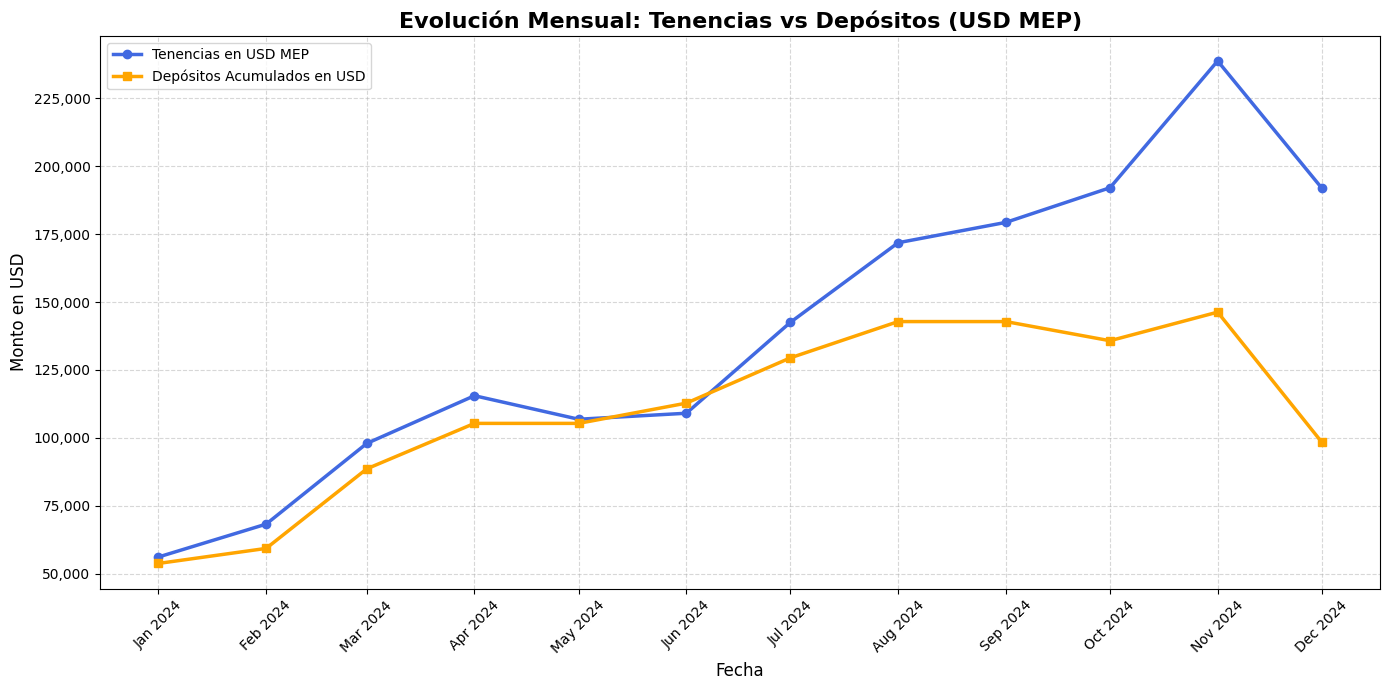

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# Convertir fechas a inicio de mes
suma_con_mep['fecha'] = pd.to_datetime(suma_con_mep['fecha']).dt.to_period('M').dt.to_timestamp()
depositos_mensual['fecha'] = pd.to_datetime(depositos_mensual['fecha']).dt.to_period('M').dt.to_timestamp()

# Merge outer para no perder valores
df_merged = pd.merge(suma_con_mep, depositos_mensual, on='fecha', how='outer').sort_values('fecha')

df_tenencias=df_merged

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(df_merged['fecha'], df_merged['total_usd'], label='Tenencias en USD MEP',
         color='royalblue', linewidth=2.5, marker='o')
plt.plot(df_merged['fecha'], df_merged['deposito_acumulado_usd'], label='Depósitos Acumulados en USD',
         color='orange', linewidth=2.5, marker='s')


# Estética del gráfico
plt.title('Evolución Mensual: Tenencias vs Depósitos (USD MEP)', fontsize=16, weight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Monto en USD', fontsize=12)

# Formato del eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Formato del eje Y
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



In [184]:
# Calcular variaciones mensuales
df_merged['variacion_tenencias'] = df_merged['total_usd'].diff()
df_merged['variacion_depositos'] = df_merged['deposito_acumulado_usd'].diff()
df_merged['Var_tenencias']=df_merged['variacion_tenencias']/df_merged['total_usd'].shift(1)
df_merged['Var_depositos']=df_merged['variacion_depositos']/df_merged['deposito_acumulado_usd'].shift(1)

# Acumulado de las variaciones mensuales
df_merged['variacion_tenencias_acumulada'] = df_merged['Var_tenencias'].cumsum()
df_merged['variacion_depositos_acumulada'] = df_merged['Var_depositos'].cumsum()
df_merged['Ganancia']=((df_merged['total_usd']-df_merged['variacion_depositos'])/df_merged['total_usd'].shift(1))-1

df_tenencia=df_merged
df_tenencia

,fecha,total,mep,total_usd,deposito_acumulado_usd,variacion_tenencias,variacion_depositos,Var_tenencias,Var_depositos,variacion_tenencias_acumulada,variacion_depositos_acumulada,Ganancia
0,2024-01-01,6.604867e+07,1175.67,56179.600100,53807.453451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-01,7.040290e+07,1031.25,68269.478691,59337.407368,12089.878591,5529.953917,0.215201,0.102773,0.215201,0.102773,0.116767
2,2024-03-01,9.956208e+07,1016.09,97985.493765,88631.617753,29716.015074,29294.210385,0.435275,0.493689,0.650476,0.596462,0.006179
3,2024-04-01,1.202633e+08,1040.89,115538.948458,105351.007635,17553.454692,16719.389882,0.179143,0.188639,0.829619,0.785101,0.008512
4,2024-05-01,1.299477e+08,1215.93,106871.076509,105351.007635,-8667.871948,0.000000,-0.075021,0.000000,0.754598,0.785101,-0.075021
5,2024-06-01,1.470379e+08,1347.96,109081.773799,112800.443032,2210.697290,7449.435397,0.020686,0.070711,0.775284,0.855811,-0.049019
6,2024-07-01,1.843865e+08,1293.33,142567.275212,129485.829133,33485.501413,16685.386101,0.306976,0.147920,1.082260,1.003731,0.154014
7,2024-08-01,2.199457e+08,1279.96,171837.943537,142819.284401,29270.668325,13333.455268,0.205311,0.102972,1.287571,1.106703,0.111787
8,2024-09-01,2.178788e+08,1215.03,179319.727834,142819.284401,7481.784297,0.000000,0.043540,0.000000,1.331111,1.106703,0.043540
9,2024-10-01,2.173157e+08,1131.46,192066.622010,135768.440166,12746.894177,-7050.844235,0.071085,-0.049369,1.402196,1.057334,0.110405


In [185]:
df_usd_ganancia=df_tenencia[['fecha','Ganancia']]
df_usd_ganancia

,fecha,Ganancia
0,2024-01-01,NaN
1,2024-02-01,0.116767
2,2024-03-01,0.006179
3,2024-04-01,0.008512
4,2024-05-01,-0.075021
5,2024-06-01,-0.049019
6,2024-07-01,0.154014
7,2024-08-01,0.111787
8,2024-09-01,0.043540
9,2024-10-01,0.110405


In [186]:
import plotly.graph_objects as go

# Crear figura
fig = go.Figure()

# Variaciones mensuales (barras, eje primario)
fig.add_trace(go.Bar(
    x=df_merged['fecha'],
    y=df_merged['Var_tenencias'] * 100,
    name='Tenencias - Variación (%)',
    marker_color='royalblue',
    yaxis='y1'
))

fig.add_trace(go.Bar(
    x=df_merged['fecha'],
    y=df_merged['Var_depositos'] * 100,
    name='Depósitos - Variación (%)',
    marker_color='orange',
    yaxis='y1'
))

# Acumulados (líneas, eje secundario)
fig.add_trace(go.Scatter(
    x=df_merged['fecha'],
    y=df_merged['variacion_tenencias_acumulada'] * 100,
    name='Tenencias - Acumulado (%)',
    mode='lines+markers',
    line=dict(color='royalblue', dash='dash'),
    yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=df_merged['fecha'],
    y=df_merged['variacion_depositos_acumulada'] * 100,
    name='Depósitos - Acumulado (%)',
    mode='lines+markers',
    line=dict(color='orange', dash='dash'),
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Variación Mensual (%) y Acumulado (%) - Tenencias vs Depósitos',
    xaxis=dict(title='Fecha', tickformat='%Y-%m'),
    yaxis=dict(title='Variación Mensual (%)', side='left'),
    yaxis2=dict(
        title='Acumulado (%)',
        overlaying='y',
        side='right'
    ),
    barmode='group',
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

fig.show()


In [187]:
import plotly.graph_objects as go

# Colores RGBA con opacidad 0.4
colores_ganancia = [
    'rgba(0, 200, 0, 0.4)' if g >= 0 else 'rgba(200, 0, 0, 0.4)'
    for g in df_tenencias['Ganancia']
]

# Crear figura
fig = go.Figure()

# Línea: Tenencias
fig.add_trace(go.Scatter(
    x=df_tenencias['fecha'],
    y=df_tenencias['total_usd'],
    name='Tenencias en USD MEP',
    mode='lines+markers',
    line=dict(color='royalblue', width=3),
    yaxis='y1'
))

# Línea: Depósitos
fig.add_trace(go.Scatter(
    x=df_tenencias['fecha'],
    y=df_tenencias['deposito_acumulado_usd'],
    name='Depósitos Acumulados USD',
    mode='lines+markers',
    line=dict(color='orange', width=3),
    yaxis='y1'
))

# Barras: Ganancia (%)
fig.add_trace(go.Bar(
    x=df_tenencias['fecha'],
    y=df_tenencias['Ganancia'] * 100,
    name='Ganancia (%)',
    marker_color=colores_ganancia,
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Tenencias vs Depósitos y Ganancia (%)',
    xaxis=dict(title='Fecha'),
    yaxis=dict(
        title='Montos en USD',
        side='left'
    ),
    yaxis2=dict(
        title='Ganancia (%)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    barmode='relative',
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

fig.show()


<Figure size 1400x700 with 0 Axes>

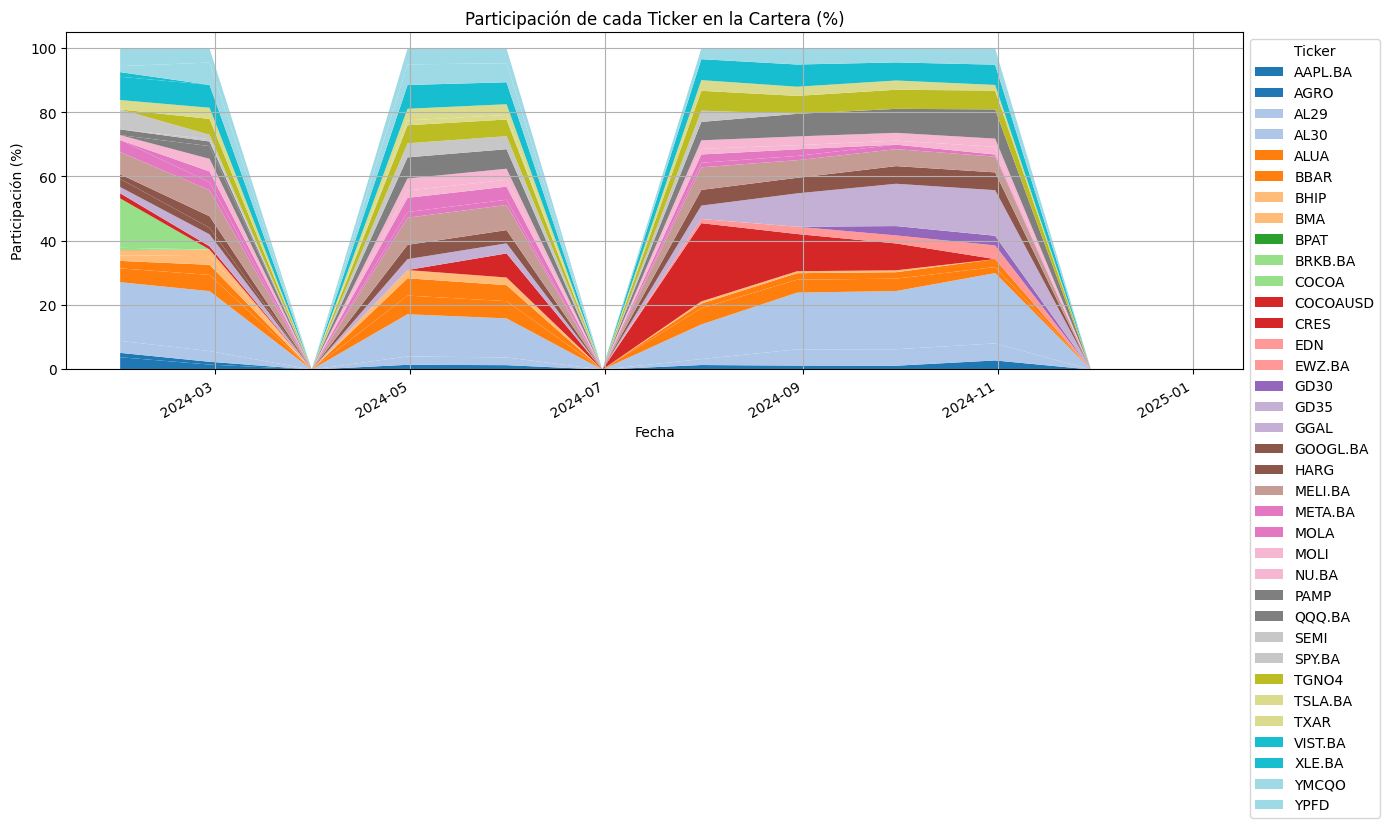

In [188]:
import matplotlib.pyplot as plt

# Filtrar filas con Ticker válido (descartar NaN, por ejemplo ARS, USD, EXT)
df_part = df.dropna(subset=['Ticker'])

# Calcular el total por fecha
total_por_fecha = df_part.groupby('fecha')['total_usd'].sum().reset_index()
total_por_fecha.rename(columns={'total_usd': 'total_cartera_usd'}, inplace=True)

# Unir el total de la cartera de vuelta al dataframe original
df_part = pd.merge(df_part, total_por_fecha, on='fecha', how='left')

# Calcular la participación porcentual
df_part['participacion_pct'] = (df_part['total_usd'] / df_part['total_cartera_usd']) * 100

# Pivotear: filas = fechas, columnas = Ticker, valores = participación %
df_pivot = df_part.pivot_table(index='fecha', columns='Ticker', values='participacion_pct', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()

# Graficar
plt.figure(figsize=(14, 7))
df_pivot.plot.area(colormap='tab20', figsize=(14, 7), linewidth=0)

plt.title('Participación de cada Ticker en la Cartera (%)')
plt.xlabel('Fecha')
plt.ylabel('Participación (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), title='Ticker')
plt.grid(True)
plt.tight_layout()
plt.show()

In [189]:
df_mep

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,especie,ultimo,variacion,anterior,apertura,minimo,maximo,varMTD,varYTD,var6M,var12M,fecha,hora,cierre,timestamp,volumen,mep
0,DOLAR MEP,36.97,NaN,NaN,36.97,36.97,36.97,NaN,NaN,NaN,NaN,2018-10-29,NaN,36.97,1540782000,0,36.97
1,DOLAR MEP,36.63,0.0,0.00,36.63,36.63,36.63,NaN,NaN,NaN,NaN,2018-10-30,19:59,36.63,1540868400,0,36.63
2,DOLAR MEP,35.93,0.0,0.00,35.93,35.93,35.93,NaN,NaN,NaN,NaN,2018-10-31,19:59,35.93,1540954800,0,35.93
3,DOLAR MEP,35.89,0.0,0.00,35.89,35.89,35.89,NaN,NaN,NaN,NaN,2018-11-01,19:59,35.89,1541041200,0,35.89
4,DOLAR MEP,35.66,0.0,0.00,35.66,35.66,35.66,NaN,NaN,NaN,NaN,2018-11-02,19:59,35.66,1541127600,0,35.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,DOLAR MEP,1164.72,0.0,1164.37,1164.37,1160.92,1175.61,NaN,NaN,NaN,NaN,2025-01-08,19:59,1164.72,1736305200,0,1164.72
1738,DOLAR MEP,1164.19,-0.0,1164.72,1164.72,1159.62,1170.42,NaN,NaN,NaN,NaN,2025-01-09,19:59,1164.19,1736391600,0,1164.19
1739,DOLAR MEP,1164.01,-0.0,1164.19,1164.19,1161.07,1174.36,NaN,NaN,NaN,NaN,2025-01-10,19:59,1164.01,1736478000,0,1164.01
1740,DOLAR MEP,1163.21,-0.1,1164.01,1164.01,1161.30,1175.23,NaN,NaN,NaN,NaN,2025-01-13,19:59,1163.21,1736737200,0,1163.21


In [190]:
import yfinance as yf
import pandas as pd

# Lista de tickers
tickers = [
   "^MERV", "SPY.BA", "YPFD.BA", "TGNO4.BA", "PAMP.BA", "MELI.BA", "HARG.BA",
    "ALUA.BA", "TXAR.BA", "EDN.BA", "MOLI.BA"
]

# Descargar todos los tickers
data = {}
for ticker in tickers:
    df = yf.download(ticker, start="2023-12-01", end="2025-01-01", progress=False)['Close']
    df.name = ticker
    data[ticker] = df

# Combinar en un único DataFrame por fecha
df_tickers = pd.concat(data.values(), axis=1)
df_tickers.index.name = 'fecha'
df_tickers = df_tickers.reset_index()

# Asegurar que df_mep tiene la fecha en datetime y columna 'ultimo'
df_mep['fecha'] = pd.to_datetime(df_mep['fecha'])
df_mep = df_mep[['fecha', 'ultimo']].dropna()

# Merge con df_mep (left join con precios)
df_merged = pd.merge(df_tickers, df_mep, on='fecha', how='left')

# Dividir cada precio por el MEP (último)
df_usd = df_merged.copy()
for ticker in tickers:
    df_usd[ticker] = df_usd[ticker] / df_usd['ultimo']

# Resultado en USD
df_usd = df_usd[['fecha'] + tickers]



/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/tmp/ipython-input-2931119484.py:13: FutureWarning:

YF.download

In [191]:
# Usar 'fecha' como índice
df_usd['fecha'] = pd.to_datetime(df_usd['fecha'])
df_usd.set_index('fecha', inplace=True)

# Asegurar orden por fecha
df_usd = df_usd.sort_index()

# Tomar el último valor de cada mes
df_mensual = df_usd.resample('M').last()

# Calcular variaciones porcentuales mensuales
variaciones_mensuales = df_mensual.pct_change().dropna()

# Mostrar resultados
print(variaciones_mensuales.head())


               ^MERV    SPY.BA   YPFD.BA  TGNO4.BA   PAMP.BA   MELI.BA  \
fecha                                                                    
2024-01-31  0.147513  0.109172  0.105533  0.114908  0.073812 -0.407185   
2024-02-29 -0.083182  0.022039 -0.043332 -0.240620 -0.177807 -0.090492   
2024-03-31  0.214899  0.058642  0.211883  0.357304  0.083737 -0.022354   
2024-04-30  0.064744 -0.053609  0.075631  0.104363  0.007078 -0.056667   
2024-05-31  0.068073  0.021557  0.031438  0.104815  0.085366  0.153266   

             HARG.BA   ALUA.BA   TXAR.BA    EDN.BA   MOLI.BA  
fecha                                                         
2024-01-31 -0.153674 -0.051159  0.018283  0.115228  0.619367  
2024-02-29  0.544264 -0.143028 -0.157634 -0.167281 -0.152406  
2024-03-31  0.015476  0.161770  0.203475  0.094083 -0.007867  
2024-04-30  0.045786 -0.072195 -0.081087 -0.058982 -0.123826  
2024-05-31  0.058280  0.025935  0.036906  0.010545  0.132796  


/tmp/ipython-input-1680914827.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [192]:
from pandas.tseries.offsets import MonthEnd

# Asegurar tipo datetime
df_usd_ganancia['fecha'] = pd.to_datetime(df_usd_ganancia['fecha'])

# Pasar del 1 de cada mes al último día de ese mes
df_usd_ganancia['fecha'] = df_usd_ganancia['fecha'] + MonthEnd(0)

# Crear serie con índice = fin de mes
df_usd_ganancia = df_usd_ganancia.set_index('fecha')['Ganancia']

/tmp/ipython-input-2716568826.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2716568826.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [193]:
df_merge = pd.concat([df_usd_ganancia,variaciones_mensuales], axis=1)
df_merge

,Ganancia,^MERV,SPY.BA,YPFD.BA,TGNO4.BA,PAMP.BA,MELI.BA,HARG.BA,ALUA.BA,TXAR.BA,EDN.BA,MOLI.BA
fecha,,,,,,,,,,,,
2024-01-31,NaN,0.147513,0.109172,0.105533,0.114908,0.073812,-0.407185,-0.153674,-0.051159,0.018283,0.115228,0.619367
2024-02-29,0.116767,-0.083182,0.022039,-0.043332,-0.240620,-0.177807,-0.090492,0.544264,-0.143028,-0.157634,-0.167281,-0.152406
2024-03-31,0.006179,0.214899,0.058642,0.211883,0.357304,0.083737,-0.022354,0.015476,0.161770,0.203475,0.094083,-0.007867
2024-04-30,0.008512,0.064744,-0.053609,0.075631,0.104363,0.007078,-0.056667,0.045786,-0.072195,-0.081087,-0.058982,-0.123826
2024-05-31,-0.075021,0.068073,0.021557,0.031438,0.104815,0.085366,0.153266,0.058280,0.025935,0.036906,0.010545,0.132796
2024-06-30,-0.049019,-0.119864,0.014094,-0.152732,-0.115020,-0.119853,-0.065660,-0.055555,-0.119797,-0.139051,-0.106869,0.035946
2024-07-31,0.154014,-0.041488,-0.000033,-0.013761,-0.039387,0.014656,0.005606,0.044099,0.010561,0.010138,0.007932,-0.138157
2024-08-31,0.111787,0.171172,0.042557,0.200578,0.089980,0.215120,0.252840,0.022439,-0.041291,-0.107297,0.195457,-0.123819
2024-09-30,0.043540,0.041072,0.026761,-0.091893,0.180857,0.109473,0.004855,0.183188,0.002391,0.049650,0.145406,0.011834


In [194]:
df_merge.rank(axis=1, ascending=False)
df_acum = (1 + df_merge).cumprod() - 1
df_acum
df_merge.std().sort_values(ascending=False)
(df_merge.mean() / df_merge.std()).sort_values(ascending=False)


,0
Ganancia,0.661454
^MERV,0.642229
EDN.BA,0.518694
SPY.BA,0.490650
YPFD.BA,0.458462
PAMP.BA,0.451576
HARG.BA,0.406582
TGNO4.BA,0.401804
MOLI.BA,0.344431
TXAR.BA,-0.007003


In [195]:
# Copia de los retornos
df_returns = df_merge.copy()
df_returns.iloc[0] = 0
df_index = (1 + df_returns).cumprod() * 100


df_index

,Ganancia,^MERV,SPY.BA,YPFD.BA,TGNO4.BA,PAMP.BA,MELI.BA,HARG.BA,ALUA.BA,TXAR.BA,EDN.BA,MOLI.BA
fecha,,,,,,,,,,,,
2024-01-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-02-29,111.676702,91.681771,102.203858,95.666838,75.938003,82.219303,90.950839,154.426382,85.697183,84.236604,83.271912,84.759389
2024-03-31,112.366700,111.384078,108.197320,115.936987,103.070960,89.104127,88.917693,156.816236,99.560380,101.376647,91.106389,84.092609
2024-04-30,113.323179,118.595500,102.397014,124.705375,113.827791,89.734815,83.878974,163.996224,92.372641,93.156280,85.732785,73.679738
2024-05-31,104.821537,126.668626,104.604403,128.625875,125.758707,97.395141,96.734797,173.553972,94.768296,96.594300,86.636820,83.464120
2024-06-30,99.683266,111.485641,106.078686,108.980524,111.293918,85.721997,90.383189,163.912241,83.415336,83.162784,77.378014,86.464295
2024-07-31,115.035879,106.860365,106.075209,107.480882,106.910433,86.978327,90.889877,171.140562,84.296266,84.005884,77.991796,74.518654
2024-08-31,127.895432,125.151890,110.589473,129.039181,116.530214,105.689116,113.870461,174.980795,80.815600,74.992308,93.235824,65.291828
2024-09-30,133.463969,130.292175,113.548908,117.181439,137.605525,117.259221,114.423325,207.035194,81.008853,78.715650,106.792863,66.064491


/tmp/ipython-input-287896442.py:13: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



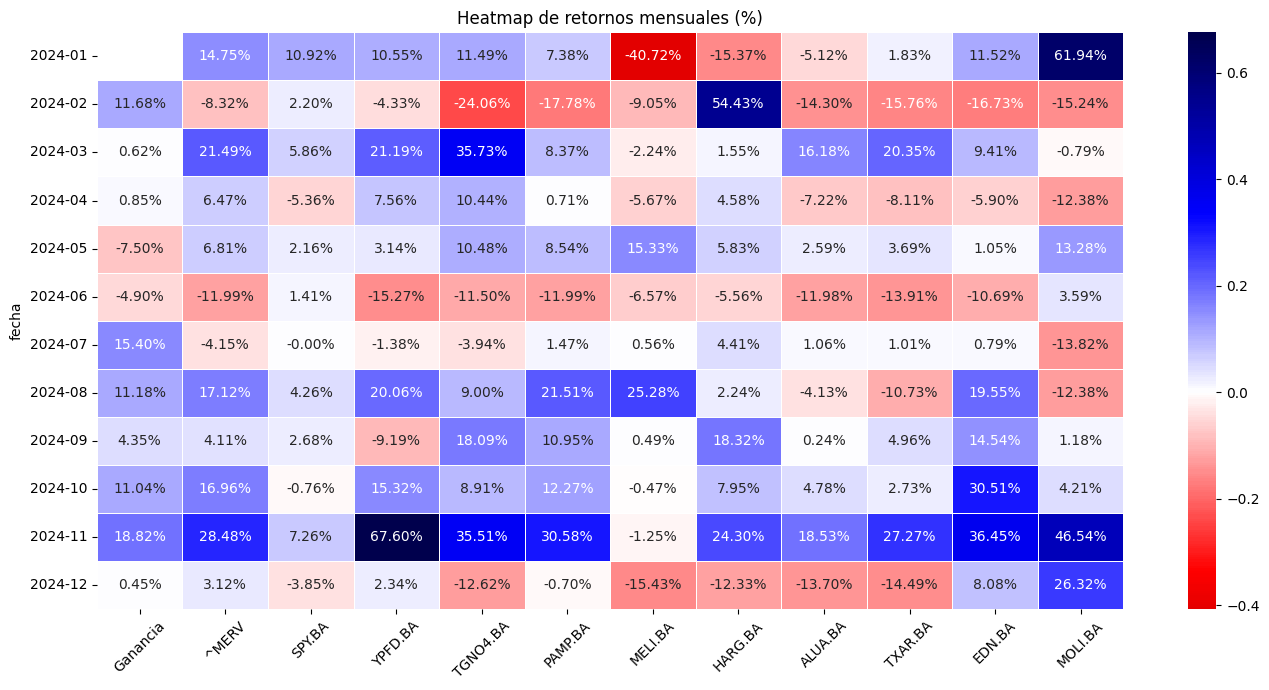

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que el índice sea datetime
df_merge.index = pd.to_datetime(df_merge.index)

# Crear copia para graficar
df_plot = df_merge.copy()
df_plot.index = df_plot.index.strftime('%Y-%m')

# --- Crear matriz de strings con porcentajes ---
annot_pct = (df_plot * 100).applymap(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")

plt.figure(figsize=(14,7))

sns.heatmap(
    df_plot,
    annot=annot_pct,
    fmt="",
    cmap='seismic_r',   # <--- ESTE es el correcto: rojo negativo, verde positivo
    center=0,
    linewidths=0.5
)

plt.title("Heatmap de retornos mensuales (%)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2641312891.py:13: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



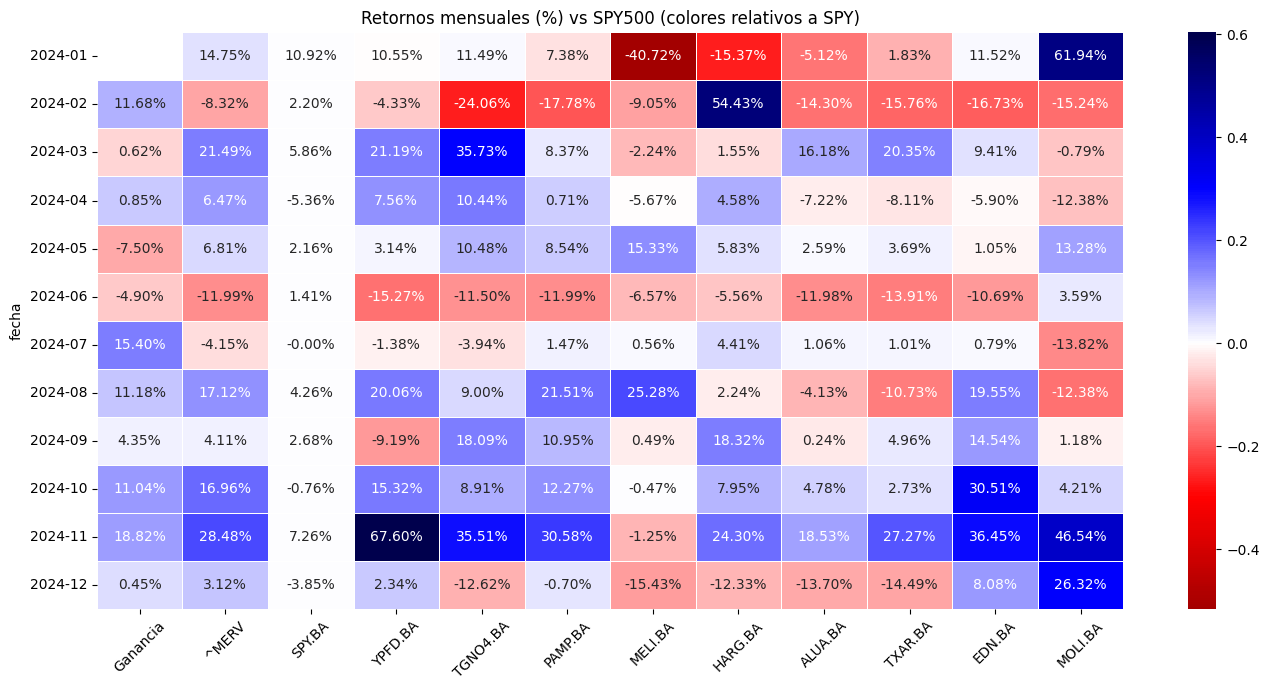

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que el índice sea datetime
df_merge.index = pd.to_datetime(df_merge.index)

# Copia para trabajar y formatear fechas
df_plot = df_merge.copy()
df_plot.index = df_plot.index.strftime('%Y-%m')

# --- Etiquetas en porcentaje (retornos originales) ---
annot_pct = (df_plot * 100).applymap(
    lambda x: f"{x:.2f}%" if pd.notnull(x) else ""
)

# --- Matriz para el color: diferencia vs SPY_usd ---
# (cada celda = retorno_activo - retorno_SPY en ese mes)
df_color = df_plot.sub(df_plot['SPY.BA'], axis=0)

plt.figure(figsize=(14,7))

sns.heatmap(
    df_color,        # ← colores según diferencia vs SPY
    annot=annot_pct, # ← texto = retornos originales en %
    fmt="",
    cmap='seismic_r',   # rojo = peor que SPY, verde = mejor que SPY
    center=0,        # 0 = igual que SPY (amarillo)
    linewidths=0.5
)

plt.title("Retornos mensuales (%) vs SPY500 (colores relativos a SPY)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2667850445.py:13: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



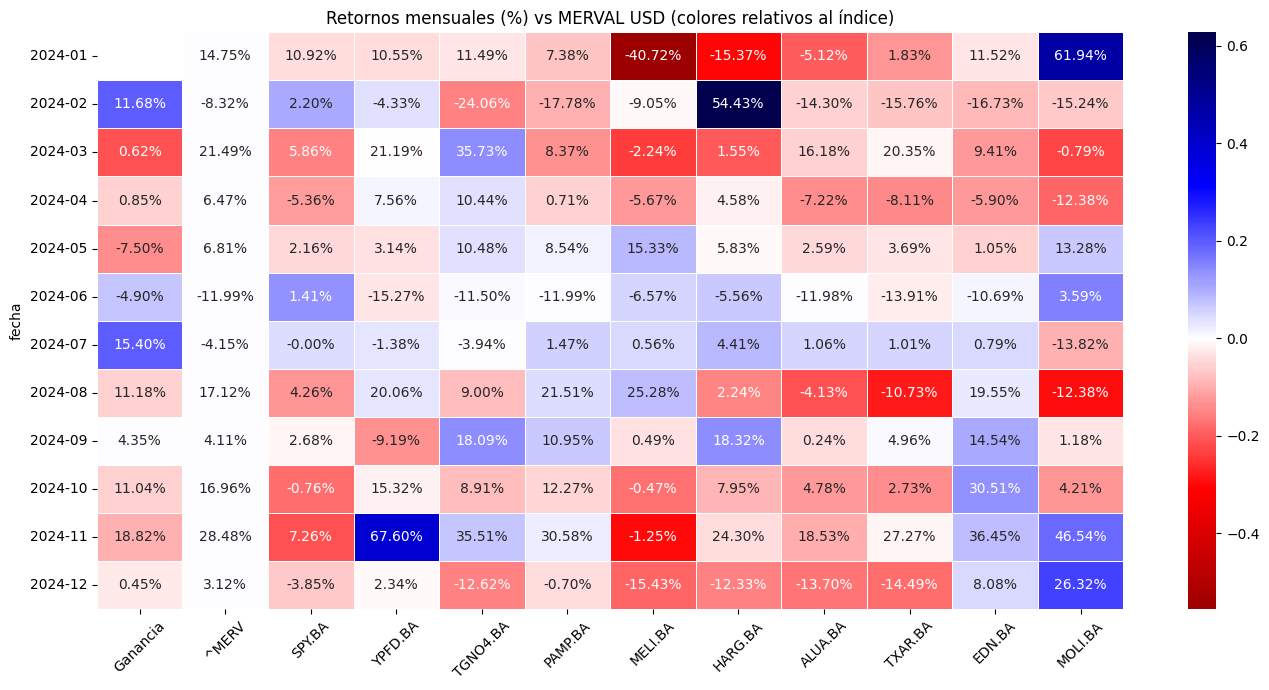

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que el índice sea datetime
df_merge.index = pd.to_datetime(df_merge.index)

# Copia para trabajar y formatear fechas
df_plot = df_merge.copy()
df_plot.index = df_plot.index.strftime('%Y-%m')

# --- Etiquetas en porcentaje (retornos originales) ---
annot_pct = (df_plot * 100).applymap(
    lambda x: f"{x:.2f}%" if pd.notnull(x) else ""
)

# --- Matriz para el color: diferencia vs Merval_usd ---
df_color = df_plot.sub(df_plot['^MERV'], axis=0)

plt.figure(figsize=(14,7))

sns.heatmap(
    df_color,         # ← COLORES según diferencia vs MERVAL
    annot=annot_pct,  # ← TEXTO = retornos originales en %
    fmt="",
    cmap='seismic_r',    # rojo = peor que MERVAL, verde = mejor
    center=0,         # 0 → igual que MERVAL
    linewidths=0.5
)

plt.title("Retornos mensuales (%) vs MERVAL USD (colores relativos al índice)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
